In [ ]:
import os
print(os.listdir("./input"))

In [ ]:
!head "./input/amazon_cells_labelled.txt"

In [36]:
import pandas as pd 
import spacy 
import numpy 
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report



from collections import Counter 

In [4]:
#read in dataset
amazon = pd.read_csv("amazon_cells_labelled.txt", sep='\t', header=None)
imdb = pd.read_csv("imdb_labelled.txt", sep='\t', header=None)
yelp = pd.read_csv("yelp_labelled.txt", sep='\t', header=None)

In [5]:
amazon.head()

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [6]:
amazon.shape

(1000, 2)

In [7]:
imdb.head()

,0,1
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [8]:
imdb.shape

(748, 2)

In [9]:
yelp.head()

,0,1
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [10]:
yelp.shape

(1000, 2)

In [11]:
#Combine imdb and yelp dataset
train_data = pd.concat([imdb, yelp])
train_data.columns = ['review', 'label']


test_data = amazon
test_data.columns = ['review', 'label']

In [12]:
train_data.shape 

(1748, 2)

In [13]:
train_data.head()

,review,label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1


In [14]:
train_review = train_data['review'].values
test_review = test_data['review'].values


In [15]:
 nlp = spacy.load('en_core_web_sm')

In [16]:
def preprocessing (review):
    
    clean_reviews = []
    
    for sentence in review:
        
        #remove numbers
        cleaned_sen = re.sub(r'\d+', ' ', sentence)
        
        #remove special characters
        cleaned_sen = re.sub(r'[^\w\s]', ' ', cleaned_sen)
        
        #remove single characters 
        cleaned_sen = re.sub(r'\s+[a-zA-Z]\s+', ' ', cleaned_sen)
        
        #convert to lowercase
        cleaned_sen = cleaned_sen.lower()
        
        docs = nlp(cleaned_sen)
        
        #remove stop words and whitespaces
        words = [token.text for token in docs if not token.is_stop | token.is_space]
        
        new_words = ' '.join(words)
        
        clean_reviews.append(new_words)
        
    return clean_reviews
    

In [17]:
clean_train_review = preprocessing(train_review)

In [18]:
print(clean_train_review[0])

slow moving aimless movie distressed drifting young man


In [19]:
#lemmatisation process 
def  lemmatizer (review):
    
    clean_review = []
    
    for sentence in review:
        
        lemma = nlp(sentence)
        
        words = [word.lemma_ for word in lemma]
        
        clean_review.append(' '.join(words))
        
    return clean_review


In [20]:
clean_train_review = lemmatizer(clean_train_review)

In [21]:
#create new dataframe for cleaned reviews
train_clean = pd.DataFrame(clean_train_review)
train_clean.columns = ['reviews']
train_clean['labels'] = train_data['label'].values
train_clean.head()

,reviews,labels
0,slow move aimless movie distress drift young man,0
1,sure lose flat character audience nearly half ...,0
2,attempt artiness black white clever camera ang...,0
3,little music speak,0
4,good scene movie gerardo try find song keep ru...,1


In [22]:
clean_test_review = preprocessing(test_review)

clean_test_review = lemmatizer(clean_test_review)


In [23]:
#create new dataframe for cleaned reviews
test_clean = pd.DataFrame(clean_test_review)
test_clean.columns = ['reviews']
test_clean['labels'] = test_data['label'].values
test_clean.head()

,reviews,labels
0,way plug converter,0
1,good case excellent value,1
2,great jawbone,1
3,tied charger conversation last minute major pr...,0
4,mic great,1


In [24]:
list_words = ''.join(clean_train_review).split()

In [25]:
#Find the 10 most frequent word in the training set
word_freq = Counter(list_words)
freq_words = word_freq.most_common(10)

In [26]:
print(freq_words)

[('movie', 143), ('film', 136), ('good', 110), ('like', 85), ('great', 73), ('bad', 71), ('food', 68), ('time', 65), ('place', 57), ('character', 48)]


In [27]:
y_train = train_clean['labels'].values
y_test = test_clean['labels'].values

In [28]:
#prepare data to be used as input for machine learning models
#using countVecotrizer to create vocabulary of uniques words from reviews
count_vectorizer = CountVectorizer(stop_words = 'english')
count_vectorizer.fit(clean_train_review)
X_train_c = count_vectorizer.transform(clean_train_review)
X_test_c = count_vectorizer.transform(clean_test_review)

In [29]:
#use vocabulary to create feature vector for each sentences in reviews.
tfidf_transform=TfidfTransformer()
X_train = tfidf_transform.fit_transform(X_train_c)
X_test = tfidf_transform.fit_transform(X_test_c)

In [38]:
#Build logistic model using gridsearchcv to find optimal parameters
lr = LogisticRegression()

param_grid = {"C":[0.001, 0.01, 0.1, 1, 10, 100], "penalty":["l1","l2"]}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring = 'accuracy')
grid_search.fit(X_train, y_train)

print("Best Param: ", grid_search.best_params_ )  


C:\Users\kangj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kangj\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kangj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\kangj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\kangj\anaconda3\lib\site-packages\sklearn\model_selection\_v

Best Param:  {'C': 1, 'penalty': 'l2'}


model = LogisticRegression(C= 1, penalty = 'l2')
model.fit(X_train, y_train)

In [32]:
y_pred = model.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred))
print("Model's Accuracy: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.83      0.78       500
           1       0.81      0.71      0.76       500

    accuracy                           0.77      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.77      0.77      1000

Model's Accuracy:  0.771


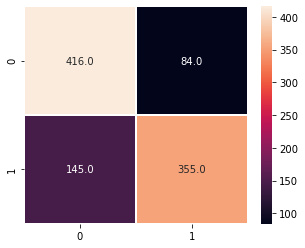

In [37]:
cm_model = confusion_matrix(y_true = y_test, y_pred = y_pred)
f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(cm_model, annot=True, linewidths=.5, fmt= '.1f',ax=ax);